In [1]:
%%time
import manager_dataset as MD
import question_processing as QP
import information_retrieval as IR
import named_entity_recognition as NER
import answer_processing as AP
from gensim.models import KeyedVectors
from util import util

c:\users\55519\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Wall time: 10.8 s


In [2]:
import warnings
warnings.filterwarnings('ignore')

### Settings

Questions recive all the questions treated

In [3]:
questions = MD.questions(treated=True)
incosiderate_classes = ['X', 'MANNER', 'OTHER', 'DEFINITION']
questions = QP.remove_incosiderate_classes(questions, incosiderate_classes)  # Question with incosiderate class is removed

Remove question with empty text

In [4]:
ret = []
for question in questions:
    if question['question'] is None or question['question'].strip() == '':
        continue
    ret.append(question)
questions = ret

In [6]:
classes ={}
for question in questions:
    if question['class'] not in classes:
        classes[question['class']] = 0
    classes[question['class']] += 1
classes

{'LOCATION': 545,
 'MEASURE': 502,
 'OBJECT': 86,
 'ORGANIZATION': 356,
 'PERSON': 582,
 'TIME': 364}

In [6]:
classes ={}
t = 0
for question in questions:
    if question['category'] not in classes:
        classes[question['category']] = 0
    classes[question['category']] += 1
    t += 1
print(classes)
print(t)

{'F': 1688, 'L': 37, 'PERSON': 32, 'TIME': 24, 'ORGANIZATION': 16, 'MEASURE': 15, 'LOCATION': 39, 'COUNT': 19, 'FACTOID': 511, 'LIST': 54}
2435


In [7]:
classes ={}
t = 0
for question in questions:
    if question['type'] not in classes:
        classes[question['type']] = 0
    classes[question['type']] += 1
    t += 1
print(classes)
print(t)

{'TIME': 340, 'PERSON': 550, 'LOCATION': 506, 'MEASURE': 368, 'ORGANIZATION': 340, 'OBJECT': 86, 'COUNT': 100, 'FACTOID': 131, 'LIST': 7, 'DEFINITION': 7}
2435


The questions that has an answer will be used for test while another questions will be used for train.

In [7]:
train_questions, test_questions = MD.split_questions(questions)

In [8]:
print(len(train_questions), len(test_questions))

1779 656


## Question Processing

In [9]:
train_questions[0].keys()

dict_keys(['id', 'id_org', 'year', 'category', 'type', 'class', 'predict_class', 'ling', 'restriction', 'answers', 'extracts', 'question'])

### Question Classification

Or Load the Word2Vec model

In [ ]:
classes_ = set()
for t in test_questions:
    classes_.add(t['class'])

In [ ]:
%%time
w2v_patch = 'C:\word_embedding\pt_cbow_s300.txt'
#w2v_patch = 'C:\word_embedding\pt_cbow_s50.txt'  # Fast test
w2v = KeyedVectors.load_word2vec_format(w2v_patch, unicode_errors="ignore")
model_w2v = {w: vec for w, vec in zip(w2v.index2word, w2v.syn0)}

In [ ]:
classes_

And Train a SVM model

In [ ]:
%%time
qc_X_train, qc_y_train = QP.separete_questions(train_questions)

classifier = QP.svm_classifier()
vectorizer = QP.HybridVectorizer(model_w2v)
#vectorizer = QP.MeanEmbeddingVectorizer(model_w2v)
#vectorizer = QP.TfidfHybridVectorizer(model_w2v)
#vectorizer = QP.SequenceHybridVectorizer(model_w2v)
#vectorizer = QP.count_vectorizer(model_w2v)
#vectorizer = QP.tfidf_vectorizer(model_w2v)
model = QP.train_model(qc_X_train, qc_y_train, classifier, vectorizer)

Or Loading the the trained SVM model

In [10]:
%%time
import dill
model = dill.load(open(QP.answer_type_file, 'rb'))

Wall time: 7.56 s


Answer type is predicted for all questions

In [11]:
%%time
questions = QP.predict_answer_type(model, test_questions)

Wall time: 503 ms


#### Testing

In [12]:
qc_X_test, qc_y_test = QP.separete_questions(test_questions)
print('Size train:',len(train_questions),'  Size test:',len(qc_y_test))

Size train: 1779   Size test: 656


Accuracy: 0.8948170731707317
Precision: 0.7493098418840777
Recall: 0.7446328717948401
F1 Score: 0.7458171451956903


<IPython.core.display.Javascript object>


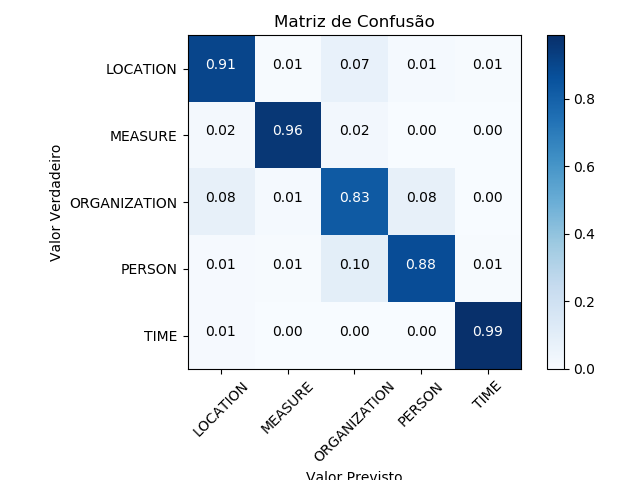

In [15]:
%matplotlib notebook
plt.close()
plt.style.use('default')
confusion_matrix = QP.testing(model, qc_X_test, qc_y_test)
plt_ = QP.plot_confusion_matrix(confusion_matrix, ['LOCATION', 'MEASURE', 'ORGANIZATION', 'PERSON', 'TIME'], normalize=True)

In [ ]:
plt_.savefig('qa_qc_mc.eps', format='eps', dpi=100)

### Query Formulation

All test questions will recive the query for IR module. 

In [16]:
%%time
test_questions = QP.queryFormulation(test_questions)

Wall time: 8.3 s


## Information Retrieval

### Document Retrieval

In [17]:
import information_retrieval as IR
ir = IR.InformationRetrieval()

Start the IR module. If the documents was not indexed then they will be.
When reset is True, all indexed documents is removed and indexed again.

In [18]:
%%time
ir.start(reset=False)

Wall time: 121 ms


In [19]:
%%time
test_questions = ir.retrievalDocuments(test_questions)

Retrieval Documents [ . . . . . . . . . . ]
Wall time: 28.4 s


In [20]:

MAX_DOCS = QP.MAX_DOCUMENTS_RETRIEVAL

results = []
for m in range(MAX_DOCS):
    results.append([])

for question in test_questions:
    relevants = [a['doc'] for a in question['answers']]
    if len(question['retrieval']) == MAX_DOCS and len(relevants) > 0:
        count = 0
        for i, r in enumerate(question['retrieval']):
            if r in relevants:
                count += 1
            results[i].append(count/(i+1))

In [21]:
len(results[0])

642

<IPython.core.display.Javascript object>


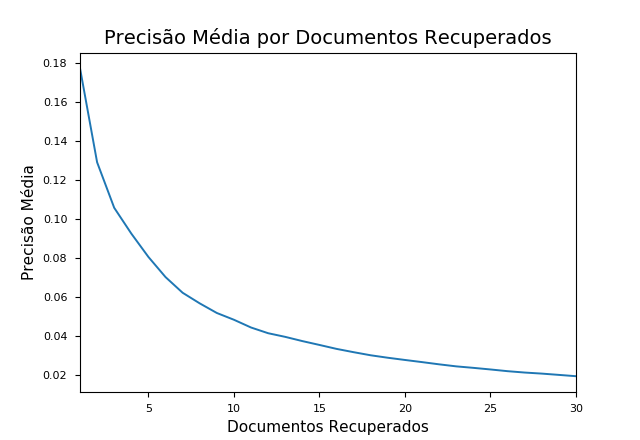

In [22]:
import numpy as np
import matplotlib.pyplot as plt

x_ = list(range(MAX_DOCS))
for i in range(len(x_)):
    x_[i] += 1
y_ = [np.mean(r) for r in results]
std = [np.std(r) for r in results]

plt.close()
plt.style.use('seaborn-paper')
plt.plot(x_, y_)
plt.xlim(1,MAX_DOCS)
plt.title('Precisão Média por Documentos Recuperados', fontsize=14)
plt.xlabel('Documentos Recuperados', fontsize=11)
plt.ylabel('Precisão Média', fontsize=11)
plt.show()

In [ ]:
plt.savefig('qa_ir_doc.eps', format='eps', dpi=100)

#### Testing

In [23]:
IR.test_ir_system(test_questions)

Precision: 0.034684776688453156
Recall: 0.7023093033509701
F-Score: 0.06221783480177429


### Named Entity Recognition

In [24]:
import importlib
importlib.reload(NER)
importlib.reload(NER.CNLP)

<module 'util.corenlp' from 'C:\\Users\\55519\\UFRGS\\QA\\qa-chave\\util\\corenlp.py'>

Train model

In [10]:
%%time
import named_entity_recognition as NER
model_ner = NER.train()

9 / 3319
19 / 3319
29 / 3319
39 / 3319
49 / 3319
59 / 3319
69 / 3319
79 / 3319
89 / 3319
99 / 3319
109 / 3319
119 / 3319
129 / 3319
139 / 3319
149 / 3319
159 / 3319
169 / 3319
179 / 3319
189 / 3319
199 / 3319
209 / 3319
219 / 3319
229 / 3319
239 / 3319
249 / 3319
259 / 3319
269 / 3319
279 / 3319
289 / 3319
299 / 3319
309 / 3319
319 / 3319
329 / 3319
339 / 3319
349 / 3319
359 / 3319
369 / 3319
379 / 3319
389 / 3319
399 / 3319
409 / 3319
419 / 3319
429 / 3319
439 / 3319
449 / 3319
459 / 3319
469 / 3319
479 / 3319
489 / 3319
499 / 3319
509 / 3319
519 / 3319
529 / 3319
539 / 3319
549 / 3319
559 / 3319
569 / 3319
579 / 3319
589 / 3319
599 / 3319
609 / 3319
619 / 3319
629 / 3319
639 / 3319
649 / 3319
659 / 3319
669 / 3319
679 / 3319
689 / 3319
699 / 3319
709 / 3319
719 / 3319
729 / 3319
739 / 3319
749 / 3319
759 / 3319
769 / 3319
779 / 3319
789 / 3319
799 / 3319
809 / 3319
819 / 3319
829 / 3319
839 / 3319
849 / 3319
859 / 3319
869 / 3319
879 / 3319
889 / 3319
899 / 3319
909 / 3319
919 / 3319

In [ ]:
{'O': 74934, 'VALOR-B': 463, 'VALOR-I': 467}

Or load model

In [25]:
%%time
import named_entity_recognition as NER
import dill
model_ner = dill.load(open(NER.file_ner, 'rb'))

Wall time: 16 ms


#### Testing

In [22]:
NER.test_approach()

Sentences: 3319 Train: 2655 Test: 664
F1-Score:0.612
                 precision    recall  f1-score   support

        VALOR-B      0.783     0.667     0.720        81
        VALOR-I      0.885     0.676     0.767        68
      OBJECTO-B      0.000     0.000     0.000         1
         OBRA-B      0.471     0.143     0.219        56
         OBRA-I      0.268     0.142     0.186       183
   ABSTRACCAO-B      0.623     0.632     0.627        76
   ABSTRACCAO-I      0.316     0.521     0.394        48
ACONTECIMENTO-B      0.636     0.292     0.400        24
ACONTECIMENTO-I      0.543     0.279     0.369        68
        TEMPO-B      0.970     0.842     0.901       114
        TEMPO-I      0.979     0.959     0.969        98
       PESSOA-B      0.738     0.689     0.712       196
       PESSOA-I      0.670     0.629     0.649       197
        LOCAL-B      0.731     0.781     0.755       219
        LOCAL-I      0.770     0.686     0.726       137
        COISA-B      0.625     0.2

In [24]:
NER.predict(model_ner, u'No Brasil, mora o aluno Eduardo Cortes. Ele estuda na UFRGS em Porto Alegre')[0]

['O',
 'LOCAL-B',
 'O',
 'O',
 'O',
 'PESSOA-B',
 'PESSOA-I',
 'O',
 'O',
 'O',
 'ORGANIZACAO-B',
 'O',
 'LOCAL-B',
 'LOCAL-I']

### Passage Retrieval

In [26]:
%%time
test_questions = IR.retrievalPassagesQuestions(test_questions, model_ner, ir)

Passages Retrieval [ start java -mx4g -cp c://corenlp/"*"  edu.stanford.nlp.pipeline.StanfordCoreNLPServer
. . . . . . . . . . ]
Wall time: 5min 50s


In [26]:
for p in test_questions[0]['passages']:
    print(p['passage_score'])

21.8
21.8
32.7
32.7
21.8
21.8
10.9
10.9
21.8
21.8
21.8
10.9
21.8
10.9
10.9
21.8
10.9
10.9
10.8
10.8
10.8
10.8
32.400000000000006
32.400000000000006
10.8
10.8
10.8
10.7
21.4
10.7
10.7
10.7
10.7
10.6
10.6
10.6
10.6
21.2
10.6
10.6
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
10.5
20.8
10.4
10.4
20.8
31.200000000000003
10.4
10.4
10.4
10.4
10.4
10.4
10.4
10.4
10.3
10.3
10.3
10.3
10.3
10.2
10.2
10.2
10.2
10.2
10.2
10.2
10.1
10.1
10.1
10.1
10.1
10.1
10.0
10.0
10.0
10.0
9.9
9.9
9.9
9.9
9.9
9.9
9.9
9.9
9.9
9.9
9.9
9.9
9.9
9.9
9.9
9.8
9.8
19.4
19.4
9.7
9.7
9.7
9.6
19.2
19.2
9.6
9.6
9.6
19.2
9.5
9.5
19.0
9.5
9.4
9.4
9.4
9.4
9.4
28.200000000000003
18.8
9.4
9.4
9.4
9.4
9.3
9.3
9.3
18.6
27.599999999999998
9.1
9.1
9.1
9.1
18.2
18.0
8.9
8.9
8.9
8.9
8.9
17.8
8.9
8.9
26.400000000000002
26.400000000000002
8.7
17.4
8.7
8.7
8.7
8.7
17.4
8.7
8.7
26.099999999999998
17.4
8.7
8.7
8.7
8.6
8.6
17.2
8.6
8.6
8.

In [30]:

MAX_ = 100

results = []
for m in range(MAX_):
    results.append([])

precisions = []
recalls = []
f_scores = []

tr_0 = 0
for question in test_questions:
    relevants = []
    for a in question['answers']:
        if a['answer'] is not None:
            relevants.append(a['answer'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').replace('\n','').replace('\r','').replace('\t','').strip())
    total_relevants = len(relevants)
    if total_relevants == 0:
        tr_0 += 1
        continue;
    relevants_retrieval = 0
    question['passages'].sort(key=lambda x: x['passage_score'], reverse=True)
    if len(question['passages']) >= MAX_ and len(relevants) > 0:
        count = 0
        for i in range(MAX_):
            for relevant in relevants:
                a_ = question['passages'][i]['passage'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').replace('\n','').replace('\r','').replace('\t','').strip()
                if a_ in relevant or relevant in a_:
                    count += 1
                    relevants_retrieval += 1
                    break
            results[i].append(count/(i+1))
    precision = relevants_retrieval / MAX_
    precisions.append(precision)
    recall = relevants_retrieval / total_relevants
    recalls.append(recall)
    if (precision + recall) == 0:
        f_score = 0
    else:
        f_score = 2 * ((precision * recall) / (precision + recall))
    f_scores.append(f_score)
print('Precision: '+str(np.mean(precisions)))
print('Recall: '+str(np.mean(recalls)))
print('F-Score: '+str(np.mean(f_scores)))    
print('tr_0:', tr_0)

Precision: 0.041021341463414636
Recall: 3.3518982288037167
F-Score: 0.08083023065332627
tr_0: 0


In [28]:
MAX_ = 100

results = []
for m in range(MAX_):
    results.append([])

precisions = []
recalls = []
f_scores = []

tr_0 = 0
trr_0 = 0

have_ra = 0
for question in test_questions:
    relevants = []
    retrievals = set()
    for a in question['answers']:
        if a['answer'] is not None:
            answ_ = a['answer'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').replace('\n','').replace('\r','').replace('\t','').strip()
            if answ_ == '':
                continue
            relevants.append(answ_)
    for r in question['passages']:
        retrieval = r['passage'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').replace('\n','').replace('\r','').replace('\t','').strip()
        if retrieval == '':
            continue
        retrievals.add(retrieval)
    total_relevants = len(relevants)
    total_retrieval = len(retrievals)
    if total_relevants == 0:
        tr_0 += 1
        continue;
    if total_retrieval == 0:
        trr_0 += 1
        continue;
    relevants_retrieval = 0
    
    for retrieval in retrievals:
        #if retrieval in relevants:
        #    relevants_retrieval += 1
        for relevant in relevants:
            if relevant in retrieval:
                relevants_retrieval += 1
                break
    if relevants_retrieval > 0:
        have_ra += 1
    precision = relevants_retrieval / total_retrieval
    precisions.append(precision)
    recall = relevants_retrieval / total_relevants
    recalls.append(recall)
    if (precision + recall) == 0:
        f_score = 0
    else:
        f_score = 2 * ((precision * recall) / (precision + recall))
    f_scores.append(f_score)
print('Precision: '+str(np.mean(precisions)))
print('Recall: '+str(np.mean(recalls)))
print('F-Score: '+str(np.mean(f_scores)))    
print('Have a righ answer:', have_ra/len(test_questions))
print('tr_0:', tr_0)
print('trr_0:', trr_0)

Precision: 0.03656249389193133
Recall: 5.773206056616195
F-Score: 0.07217472628968956
Have a righ answer: 0.6524390243902439
tr_0: 0
trr_0: 5


<IPython.core.display.Javascript object>


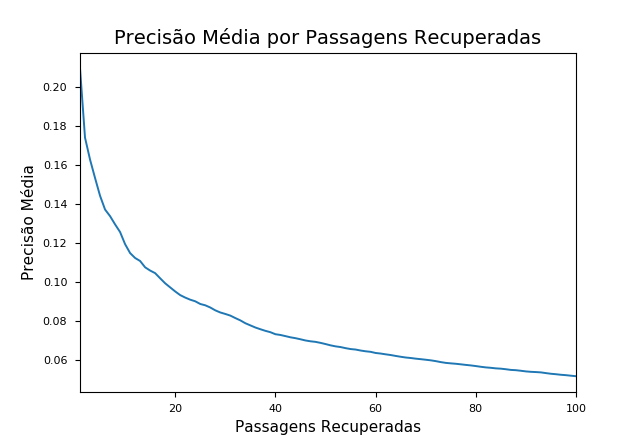

In [31]:
import numpy as np
import matplotlib.pyplot as plt

x_ = list(range(MAX_))
for i in range(len(x_)):
    x_[i] += 1
y_ = [np.mean(r) for r in results]
std = [np.std(r) for r in results]

plt.close()
plt.style.use('seaborn-paper')
plt.plot(x_, y_)
#plt.errorbar(x_, y_, std)
plt.xlim(1,MAX_)
plt.title('Precisão Média por Passagens Recuperadas', fontsize=14)
plt.xlabel('Passagens Recuperadas', fontsize=11)
plt.ylabel('Precisão Média', fontsize=11)
plt.show()

In [29]:
results[1]

[0.5,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.5,
 0.0,
 0.0,
 0.5,
 0.0,
 0.5,
 0.0,
 1.0,
 0.5,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.5,
 0.0,
 0.5,
 0.5,
 1.0,
 0.0,
 1.0,
 0.0,
 0.5,
 0.5,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5,
 1.0,
 0.0,
 0.0,
 0.0,
 0.5,
 1.0,
 0.5,
 0.0,
 0.0,
 0.5,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5,
 0.5,
 0.5,
 1.0,
 0.0,
 0.0,
 0.5,
 0.0,
 0.5,
 0.0,
 0.0,
 1.0,
 0.5,
 0.5,
 0.5,
 0.0,
 0.0,
 0.0,
 0.5,
 0.0,
 0.5,
 0.5,
 0.5,
 0.5,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5,
 1.0,
 0.0,
 0.0,
 0.0,
 0.5,
 0.5,
 0.5,
 0.0,
 0.5,
 0.5,
 0.5,
 0.5,
 0.0,
 0.5,
 0.5,
 0.0,
 0.5,
 1.0,
 0.0,
 0.5,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.5,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5,
 0.5,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5,
 0.0,
 0.0,
 0.5,
 0.0,
 0.5,
 0.0,
 0.0,
 0.5,
 0.0,
 0.0,
 0.5,
 0.0,
 0.5,
 0.0,
 0.0,
 1.0,
 0.5,
 1.0

In [372]:
plt.savefig('qa_ir_passage.eps', format='eps', dpi=100)

## Answer Processing

In [31]:
test_questions[0]['answers']

[{'answer': '\nMilão\n', 'doc': 'PUBLICO-19940724-039', 'n': '2'}]

### Answer Extraction

In [32]:
%%time
test_questions = AP.answer_candidates(test_questions, ir, model_ner)

Answer Candidates [ . . . . . . . . . . ]
Wall time: 13 s


### Final Answer Selection

In [33]:
%%time
test_questions = AP.finals_answer(test_questions)
#for c in test_questions[0]['answer_candidates']:
#    print(c['passage_score'])

Final Answer[ . . . . . . . . . . ]
Wall time: 860 ms


In [34]:
print(test_questions[0]['question'])
print(test_questions[0]['query'])
print(test_questions[0]['answers'])
#for ac in test_questions[1]['answer_candidates']:
#    print(float(("%0.1f"%ac['doc_rank'])), float(("%0.1f"%ac['votes'])), float(("%0.1f"%ac['score'])))


Em que cidade se encontra a prisão de San Vittore?
{'fl': 'id', 'rows': '30', 'q': 'cidade encontra prisão san vittore', 'defType': 'edismax', 'qf': 'text', 'pf': 'text', 'ps': '15', 'pf2': 'text', 'ps2': '15', 'pf3': 'text', 'ps3': '15', 'wt': 'json', 'indent': 'false'}
[{'answer': '\nMilão\n', 'n': '2', 'doc': 'PUBLICO-19940724-039'}]


In [ ]:
import pprint
pp = pprint.PrettyPrinter()
pp.pprint(test_questions[0])

#### Testing

In [ ]:
test_questions[0]['query']['q']

Check if the answer_candidates have the right answer

In [36]:
AP.test_answer_candidates(test_questions)

656 / 470
Result: 71.646 %

Correct answer type:
587 / 430
Result: 73.254 %


In [366]:
MAX_ = 200

results = []
for m in range(MAX_):
    results.append([])

for question in test_questions:
    #relevants = [a['answer'] for a in question['answers'] if a['answer'] is not None]
    relevants = []
    for a in question['answers']:
        if a['answer'] is not None:
            relevants.append(a['answer'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').replace('\n','').replace('\r','').replace('\t','').strip())
        
    question['answer_candidates'].sort(key=lambda x: x['score'], reverse=True)
    if len(question['answer_candidates']) >= MAX_ and len(relevants) > 0:
        count = 0
        for i in range(MAX_):
            for relevant in relevants:
                a_ = question['answer_candidates'][i]['full_answer'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').replace('\n','').replace('\r','').replace('\t','').strip()
                if a_ in relevant or relevant in a_:
                    count += 1
                    break
            results[i].append(count/(i+1))

In [ ]:
test_questions[0]['answers']

<IPython.core.display.Javascript object>


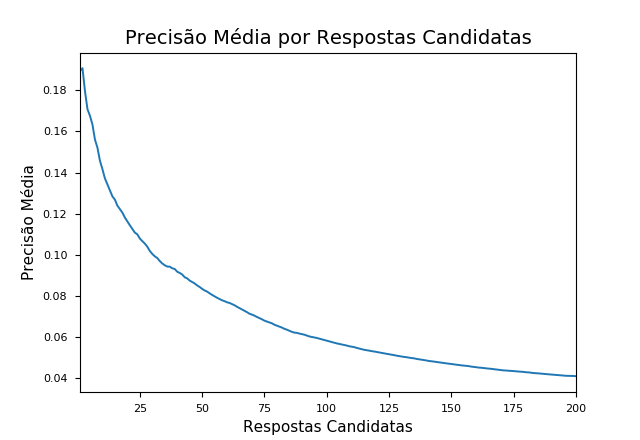

In [367]:
import numpy as np
import matplotlib.pyplot as plt

x_ = list(range(MAX_))
for i in range(len(x_)):
    x_[i] += 1
y_ = [np.mean(r) for r in results]
std = [np.std(r) for r in results]

plt.close()
plt.style.use('seaborn-paper')
plt.plot(x_, y_)
#plt.errorbar(x_, y_, std)
plt.xlim(1,MAX_)
plt.title('Precisão Média por Respostas Candidatas', fontsize=14)
plt.xlabel('Respostas Candidatas', fontsize=11)
plt.ylabel('Precisão Média', fontsize=11)
plt.show()

In [368]:
plt.savefig('qa_ir_answers.eps', format='eps', dpi=100)

## Final Evaluate

In [ ]:
total = len(test_questions)
right = 0

cc_total = 0  # Total of question with correct candidates
cc_right = 0

for question in test_questions:
    aux = False
    if question['correct_answers_candidates']:
        aux = True
        cc_total += 1
    question['correct_final_answer'] = False
    for answer in question['answers']:
        if answer['answer'] is not None:
            a1 = answer['answer'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').strip()
            a2 = question['final_answer'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').strip()
            if a1 in a2 or a2 in a1:
                question['correct_final_answer'] = True
                right += 1
                if aux:
                    cc_right += 1
                break
print(str(total) + ' / ' + str(right))
print('Accuracy: '+ '%.3f' % ((right/total)*100)+' %')
print('\nCorrect answer candidates:\n' + str(cc_total) + ' / ' + str(cc_right))
print('Accuracy: '+ '%.3f' % ((cc_right/cc_total)*100)+' %')

Question Analysis

In [ ]:
print('Q = Question\nSA = System Answer\nCA = Correct Answer(s)')


print('\n##### Correct Answers #####\n')
for i in range(len(test_questions)):
    if test_questions[i]['correct_final_answer']:
        print('Index: ' + str(i))
        print('Q: ' + test_questions[i]['question'])
        print('SA: ' + test_questions[i]['final_answer'])
        print('CA: ', end='')
        for answer in test_questions[i]['answers']:
            if answer['answer'] is not None:
                print(answer['answer'].strip(), end=' | ')
        print('\n')


    


In [ ]:
print('\n##### Wrong Answers #####\n')
for i in range(len(test_questions)):
    if not test_questions[i]['correct_final_answer']:
        print('Index: ' + str(i))
        print('Q: ' + test_questions[i]['question'])
        print('SA: ' + test_questions[i]['final_answer'])
        print('CA: ', end='')
        for answer in test_questions[i]['answers']:
            if answer['answer'] is not None:
                print(answer['answer'].strip(), end=' | ')
        print('\n')


In [ ]:
for c in test_questions[0]['answer_candidates']:
    print(c['score'], c['votes'])

In [ ]:
sorted(test_questions[0]['answer_candidates'], key=lambda k: k['score'])[-1]

## Util

### Detailed Question Analysis

In [ ]:
question = {
    'question': u'Onde era o campo de concentração de Auschwitz?',
    'class': 'LOCATION'
}

question = test_questions[28]

print('Question: ' + question['question'])
print('Class: ' + question['class'])

# Question Classification
QP.predict_answer_type(model, [question])
print('Answer Type: ' + question['predict_class'])

# Query Formulation
QP.queryFormulation([question])
print('Query: ' + question['query']['q'])

# Document Retrieval
ir.retrievalDocuments([question])
print('Number of retrieval documents: ' + str(len(question['retrieval'])))

# Passages Retrieval
IR.retrievalPassagesQuestions([question], model_ner, ir)

# Answers Candidates
AP.answer_candidates([question], QP, ir, NER, model_ner)
print('Number of answer candidates: ' + str(len(question['answer_candidates'])))

# Final Answer
AP.finals_answer([question])
print('Answer: ' + question['final_answer'])

if 'answers' in question:
    print('Correct Answers: ', end='')
    for answer in question['answers']:
        if answer['answer'] is not None:
            print(answer['answer'].strip(), end=' | ')

In [ ]:
for p in question['passages']:
    print(p['doc_id'],'\n',p['passage'], '\n')

Show documents id

In [ ]:
print('Retrieval Documents ID: ', end='')
for doc_id in question['retrieval']:
    print(doc_id, end=', ')

if 'answers' in question:
    print('\n\nRelevants Documents ID: ', end='')
    for answer in question['answers']:
        if answer['doc'] is not None and len(answer['doc']) > 0:
            print(answer['doc'], end=', ')

Show documents texts

In [ ]:
for doc_id in question['retrieval']:
    print('\n'+doc_id+'\n'+ir.documentText(doc_id))

In [ ]:
doc_id = 'PUBLICO-19940929-035'
print('\n'+doc_id+'\n'+ir.documentText(doc_id))

Show answers candidates

In [ ]:
for ac in question['answer_candidates']:
    print(ac['full_answer'])

Show most vote answer candidates

In [ ]:
import operator
votes = {}
for candidate in question['answer_candidates']:
    if candidate['full_answer'].lower() not in question['question'].lower():
        if candidate['full_answer'] not in votes:
            votes[candidate['full_answer']] = candidate['score']
[(k, votes[k]) for k in sorted(votes, key=votes.get, reverse=True)]

In [ ]:
for x in sorted(question['answer_candidates'], key=lambda k: k['score'])[::-1]:
    print(float(("%0.2f"%x['doc_rank'])), float(("%0.2f"%x['votes'])), float(("%0.2f"%x['score'])))  

In [ ]:
NER.predict(model_ner, u'Michael Jackson casou-se com a filha de Elvis Presley')[0]

### Others

In [ ]:
ir.stop()

In [ ]:
import importlib
importlib.reload(AP)
#raise IpyExit

In [ ]:
import CoreNLP

def retrieval_passages(questions, ner_model):
    for question in questions:
        question['passages'] = []
        for document in question['documents']:
            passages = CoreNLP.ssplit(document_text)
            for passage in passages:
                entities = ner_model.predict(passage)
                if question['predict_class'] not in entities:
                    continue
                passage_score = 0
                for key_word in question['query'].split():
                    passage_score += passage.count(key_word)
                passage_score = (1+passage_score) * ((-document.rank + MAX_DOC)/MAX_DOC)
                question['passages'].append({
                    'passage': passage, 'entities': entities, 
                    'passage_score': passage_score
                    })
    return questions

In [ ]:
def word2features(sentence, word_index):
    sentence = ' '.join([x[0] for x in sent])
    word = sentence[word_index]
    features = {
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    return features

In [ ]:
ANSWER_CANDIDATES_PARAMETERS_WEIGHT = {'doc_rank': -0.9, 'votes': 0.7, 'passage_score': 0.7}


def answer_candidates(questions):
    for question in questions:
        question['answer_candidates'] = []
        for passage in question['passages']:
            control = False
            for entity in passage['entities']:
                if entity != 'O':
                    class_entity = entity[:entity.index('-')].lower()
                    if class_entity == question['predict_class'].lower():
                        control = True
                        break
            if not control:
                continue

            candidate = {'answer': '', 'votes': 0, 'doc_rank': passage['doc_rank'], 
                         'passage_score': passage['passage_score']}

            last = False
            words = passage['passage'].split()
            for index in range(len(words)):
                word = words[index]
                entity = passage['entitys'][index]

                if entity != 'O': 
                    class_entity = entity[:entity.index('-')].lower()
                    suffix = entity[entity.index('-') + 1:].lower()
                    if suffix == 'b':  # Inicio da entidade mencionada
                        if candidate['full_answer'] != '':
                            insert_candidate(question, candidate)
                            candidate = {'passage_text': passage['passage'], 'words': [], 'full_answer': '', 'votes': 0, 'doc_rank': passage['doc_rank'], 'passage_score': passage['passage_score']}
                    if class_entity == QP.classPT(question['predict_class'].lower()).lower():
                        candidate['words'].append((word, index))
                        candidate['full_answer'] += ' ' + word
                        candidate['full_answer'] = candidate['full_answer'].strip()
                        last = True
                    else:
                        last = False
                else:
                    if last:
                        if not candidate['full_answer'] == '':
                            insert_candidate(question, candidate)
                            candidate = {'passage_text': passage['passage'], 'words': [], 'full_answer': '', 'votes': 0, 'doc_rank': passage['doc_rank'], 'passage_score': passage['passage_score']}
                    last = False
            if not candidate['full_answer'] == '':
                insert_candidate(question, candidate)
                candidate = {'passage_text': passage['passage'], 'words': [], 'full_answer': '', 'votes': 0, 'doc_rank': passage['doc_rank'], 'passage_score': passage['passage_score']}
    if printing:
        print('. ]')
    return questions

In [ ]:
ANSWER_CANDIDATES_PARAMETERS_WEIGHT = {'doc_rank': -0.9, 'votes': 0.7, 
                                       'passage_score': 0.7}

def answer_candidates(questions):
    
    candidates = []
    
    for question in questions:
        question['answer_candidates'] = []
        for passage in question['passages']:
            control = False
            for entity in passage['entities']:
                if entity != 'O':  # Se é uma entidade mencionada
                    class_entity = entity[:entity.index('-')].lower()
                    if class_entity == question['predict_class'].lower():
                        control = True
                        break
            if not control:
                continue

            candidate = {'answer': '', 'votes': 0, 'doc_rank': passage['doc_rank'], 
                         'passage_score': passage['passage_score']}
            last = False
            words = passage['passage'].split()
            for index in range(len(words)):
                word = words[index]
                entity = passage['entitys'][index]

                if entity != 'O':  # Se é uma entidade mencionada
                    class_entity = entity[:entity.index('-')].lower()
                    suffix = entity[entity.index('-') + 1:].lower()
                    if suffix == 'b':  # Inicio da entidade mencionada
                        if candidate['answer'] != '':
                            insert_candidate(question, candidate)
                            candidate = {'answer': '', 'votes': 0, 
                                         'doc_rank': passage['doc_rank'], 
                                         'passage_score': passage['passage_score']}
                    if class_entity == question['predict_class'].lower():
                        candidate['answer'] += ' ' + word
                        last = True
                    else:
                        last = False
                else:
                    if last:
                        if candidate['answer'] != '':
                            insert_candidate(question, candidate)
                            candidate = {'answer': '', 'votes': 0, 
                                         'doc_rank': passage['doc_rank'], 
                                         'passage_score': passage['passage_score']}
                    last = False
            if candidate['answer'] != '':
                insert_candidate(question, candidate)
                candidate = {'answer': '', 'votes': 0, 'doc_rank': passage['doc_rank'], 
                             'passage_score': passage['passage_score']}
    return questions

In [ ]:
WEIGHTS = {'doc_rank': -0.9, 'votes': 0.7, 'passage_score': 0.7}


def final_answers(questions):
    
    for question in questions:
        question['final_answer'] = ''
        normalize_parameters(question['answer_candidates'])
        
        # Determinar o score de cada answer candidate
        for candidate in question['answer_candidates']:
            candidate['score'] = 0
            for weight in WEIGHTS:
                candidate['score'] += candidate[weight] * WEIGHTS[weight]
                
        # Atribui a resposta final para cada questão
        if len(question['answer_candidates']) > 0:
            rank = sorted(question['answer_candidates'], key=lambda k: k['score'])
            question['final_answer'] = rank[-1]['full_answer']
    
    return questions

In [ ]:
def pair_classification(category, type_):
    if category == 'COUNT':
        return 'MEASURE'
    if category == 'D' or category == 'DEFINITION':
        return 'DEFINITION'
    if category == 'F' or category == 'FACTOID':
        if type_ == 'COUNT':
            return 'MEASURE'
        elif type_ == 'MANNER':
            return 'DEFINITION'
        return type_
    if category == 'L' or category == 'LIST':
        if type_ == 'COUNT':
            return 'MEASURE'
        else:
            return type_
    if category == 'LOCATION':
        return 'LOCATION'
    if category == 'MEASURE':
        return 'MEASURE'
    if category == 'OBJECT':
        return 'DEFINITION'
    if category == 'ORGANIZATION':
        return 'ORGANIZATION'
    if category == 'OTHER' and (type_ == 'FACTOID' or type_ == 'LIST'):
        return 'OTHER'
    if category == 'OTHER' and not (type_ == 'FACTOID' or type_ == 'LIST'):
        if type_ == 'MANNER':
            return 'DEFINITION'
        return type_
    if category == 'PERSON' and type_ == 'DEFINITION':
        return 'DEFINITION'
    if category == 'PERSON' and not type_ == 'DEFINITION':
        return 'PERSON'
    return category